In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
from keras.layers import Input

import cv2
import shutil
import glob
import os

In [2]:
base_path='../input/braintumor/Brain/train'
filepaths=[]
labels=[]
for (dir_path, dir_names, file_names) in os.walk(base_path):
    for i in file_names:
        filepaths.append(dir_path+'/'+i)
        if 'Tr-no' in (i.split('_')):
            labels.append("No")
        else: 
            labels.append("Yes")
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  5712    labels:  5712


In [3]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(5712,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
1,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
2,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
3,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
4,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes


In [4]:
print(df['labels'].value_counts())

Yes    4128
No     1584
Name: labels, dtype: int64


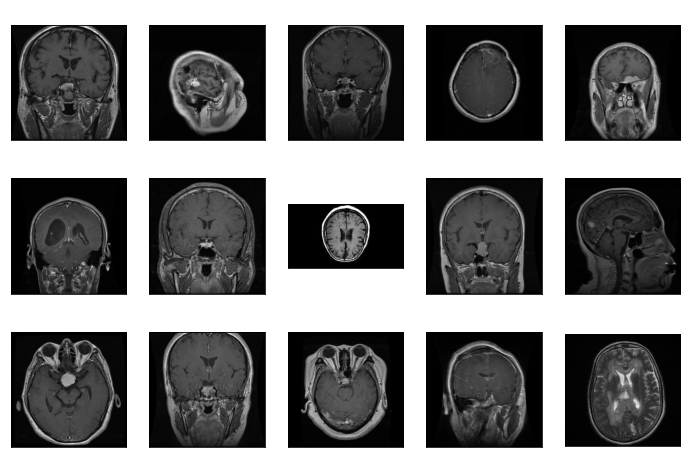

In [5]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.80, random_state=0)
train_new, valid = train_test_split(train, train_size=0.85, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (3883, 2)
test set shape: (1143, 2)
validation set shape: (686, 2)


In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [8]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (150,150), batch_size = 16, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(150,150), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 3883 validated image filenames belonging to 2 classes.
Found 686 validated image filenames belonging to 2 classes.
Found 1143 validated image filenames belonging to 2 classes.


In [9]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [10]:
input_data = Input(shape=(200,200,3), name='input')

base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

2022-09-08 19:59:09.825090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 19:59:09.966991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 19:59:09.971109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 19:59:09.976148: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

219070464/219055592 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
batch_normalization_203 (Bat (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 54,534,113
Trainable params: 54,473,313
N

In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
]


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001), metrics=['accuracy',tf.keras.metrics.AUC(
    num_thresholds=200,
    curve="ROC",
    summation_method="interpolation",
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    label_weights=None,
),tf.keras.metrics.Precision( thresholds=None, top_k=None, class_id=None, name=None, dtype=None ),tf.keras.metrics.Recall( thresholds=None, top_k=None, class_id=None, name=None, dtype=None ),tf.keras.metrics.TruePositives(thresholds=None, name=None, dtype=None),tf.keras.metrics.TrueNegatives(thresholds=None, name=None, dtype=None),tf.keras.metrics.FalsePositives(thresholds=None, name=None, dtype=None),tf.keras.metrics.FalseNegatives(thresholds=None, name=None, dtype=None)])


history = model.fit(train_gen, validation_data = val_gen, epochs = 40, callbacks = [callbacks], verbose = 1)

2022-09-08 19:59:24.047406: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-09-08 19:59:48.636360: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


243/243 [==============================] - 114s 338ms/step - loss: 0.2608 - accuracy: 0.9099 - auc: 0.9605 - precision: 0.9574 - recall: 0.9166 - true_positives: 2584.0000 - true_negatives: 949.0000 - false_positives: 115.0000 - false_negatives: 235.0000 - val_loss: 0.1163 - val_accuracy: 0.9665 - val_auc: 0.9864 - val_precision: 0.9684 - val_recall: 0.9859 - val_true_positives: 490.0000 - val_true_negatives: 173.0000 - val_false_positives: 16.0000 - val_false_negatives: 7.0000
Epoch 2/40
243/243 [==============================] - 63s 259ms/step - loss: 0.1425 - accuracy: 0.9601 - auc: 0.9846 - precision: 0.9700 - recall: 0.9752 - true_positives: 2749.0000 - true_negatives: 979.0000 - false_positives: 85.0000 - false_negatives: 70.0000 - val_loss: 0.0534 - val_accuracy: 0.9854 - val_auc: 0.9990 - val_precision: 0.9919 - val_recall: 0.9879 - val_true_positives: 491.0000 - val_true_negatives: 185.0000 - val_false_positives: 4.0000 - val_false_negatives: 6.0000
Epoch 3/40
243/243 [=======

In [12]:
model.load_weights("Tumor_classifier_model.h5")
model.evaluate(test_gen)

72/72 [==============================] - 10s 142ms/step - loss: 0.0844 - accuracy: 0.9869 - auc: 0.9969 - precision: 0.9963 - recall: 0.9852 - true_positives: 800.0000 - true_negatives: 328.0000 - false_positives: 3.0000 - false_negatives: 12.0000


[0.08441313356161118,
 0.9868766665458679,
 0.9969415664672852,
 0.9962639808654785,
 0.9852216839790344,
 800.0,
 328.0,
 3.0,
 12.0]

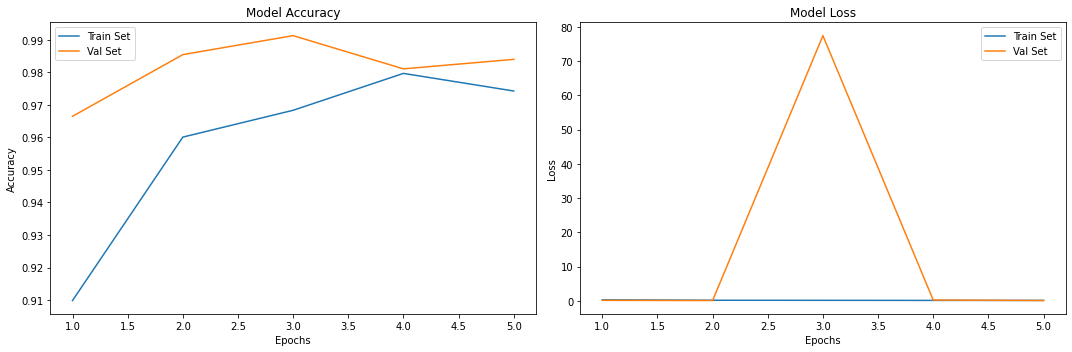

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()